# Suflur Dioxide and Seismic Data Processing

## Sulfur Dioxide Data Processing using NASA GES Data

Using the [NASA GES DISC Database](https://disc.gsfc.nasa.gov/datasets/OMPS_NPP_NMSO2_PCA_L2_2/summary?keywords=sulfur%20dioxide), select the dates and region of data to download.

The data is stored in h5 files, which requires h5py to read and interpret.

This program utilizes a text file with all of the names of the files on individual lines. This is so the program can read the file names off the lines directly into a list.

Below are the packages to import:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
import h5py
import imageio
from PIL import Image

### Helper Functions

Functions for easy processing the files into a dataframe, plotting the data on a shaded releif map using cartopy and matplotlib, and saving the figure as a PNG, and an import for the shaded relief map style.

In [2]:
def dataset(path, file, keys, columns):
    '''
    Reads h5 file dataset, the keys to the specifc table, and returns a dataframe with the data in column form. 
    Do not put date as the first key or column, as this will break the function. 
    Start with Latitude, Longitude, or SO2 Column
    -----------
    Parameters:
        path: Local or Absolute filepath to h5 file
        file: Name of h5 file
        keys: List of keys to use. i.e. 'GEOLOCATION_DATA/Latitude'
        columns: List of Column names to use in DataFrame i.e. 'latitude'
    -----------
    Returns:
        df: the dataframe of the specific data called upon in the function
    '''
    # Create DataFrame object
    df = pd.DataFrame()

    # iterate through keys and columns
    for key, column in zip(keys, columns):
        # Read the data from the specific table in the file, convert to numpy array
        array = np.array(h5py.File(f'{path}{file}')[key])

        # Try to flatten and add to DataFrame
        try:
            df[column] = array.flatten()

        # If it fails, date table. 
        except:
            repeat = len(df)  # Get num of rows in DataFrame to create proper length array of dates
            date = array[0].decode('UTF-8').split('T')[0]  # Use first value of the array and extract only the date
            date_arr = np.repeat(np.array(date), repeat)  # Make numpy array with matching length
            df[column] = date_arr
    
    return df

In [3]:
def plot(df, date):
    '''
    Given a data frame, plot the data on a geospatial map with shaded releif.
    Saves as a PNG file in the figures folder
    -----------
    Parameters:
    df: Pandas DataFrame of data to be plotted
    date: The date within the dataframe to plot
    '''
    # reduce dataframe to values only on specified date
    df = df[df.date == date]

    # plot the data onto a map with shaded relief. Includes coastlines, oceans, rivers, and lakes. 
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=ShadedReliefESRI().crs)
    ax.set_extent(extent)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    ax.add_feature(cfeature.RIVERS)
    ax.coastlines()
    # gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    # place a marker on the volcano
    ax.scatter(lon_sabancaya, lat_sabancaya, marker='^', color='k', transform=ccrs.PlateCarree())
    # scatter plot the data. Cmap by the so2 values.
    cs = ax.scatter(df.longitude, df.latitude, c=df.so2,
               transform=ccrs.PlateCarree(), cmap='YlOrRd',
               vmin=0, vmax=10)
    # Colorbar parameters
    cax = fig.add_axes([.95, .25, .02, .5])
    cbar = plt.colorbar(cs, cax=cax, label=u'SO\u2082 [DU]')
    ax.add_image(ShadedReliefESRI(), 8)
    ax.set_title(f'Atmospheric Sulfur Dioxide {date}', fontsize=20)
    
    plt.savefig(f'../figures/gif-pngs/{date}-so2.png', bbox_inches='tight')
    plt.show()

In [4]:
# Shaded relief map style
class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

### Bulk Code

Load the files into a list using a .txt file, process the data using the dataset function, then plot that data on a map using the plot function. The .png files are used to make a .gif of the movement of sulfur dioxide over time. 

Next, the total sulfur dioxide in the image is added up and plotted as a time series to show the amount present in the atmosphere. Using the data from the seismic notebook, the total number of earthquakes recorded in a year is plotted on the same plot as the total amount of sulfur dioxide in a year to identify any correlations

In [5]:
# Read text file with all of the h5 file names on separate lines
# Place each file name as a unique entry in a list
with open('../data/sabancaya/so2-data/file-names.txt', 'r') as files:
    file_list = files.read().splitlines()

In [6]:
# lists with the parameters for the dataset function
path = '../data/sabancaya/so2-data/OMPS-NPP/'
keys = ['GEOLOCATION_DATA/Latitude', 'GEOLOCATION_DATA/Longitude', 'SCIENCE_DATA/ColumnAmountSO2', 'GEOLOCATION_DATA/UTC_CCSDS_A']
columns = ['latitude', 'longitude', 'so2', 'date']

In [7]:
# Create list objects for the data frames and the dates
df_list = []
dates_list = []
for file in file_list:
    # convert the file into a dataframe, append to a list
    try:
        df = dataset(path, file, keys, columns)
        df_list.append(df)
        dates_list.append(df.date.iloc[0])
    # print the name of files that do not fit the format
    except:
        print(f"File '{file}' does not work")
# concatenate df_list into a single dataframe
df = pd.concat(df_list)

File '' does not work


In [8]:
# Merge any duplicate dates to ensure only one entry per date, then sort
dates_list = list(set(dates_list))
dates_list.sort()

In [9]:
# Latitude and Longitude of Vulcan Sabancaya
lon_sabancaya, lat_sabancaya = -71.857, -15.787
# Map Extents
extent = [-85.857, -66.857, -10.787, -21.79]

# Refine DataFrame to within the map extents and any sulfur dioxide above .25 DU
# Restricting to points above .25 reduces noise and makes the data easier to visualize
df_refined = df[(df.longitude >= extent[0]) & (df.longitude <= extent[1]) &
                (df.latitude >= extent[3]) & (df.latitude <= extent[2]) &
                (df.so2 > .25)]

In [10]:
# plot the so2 data for each date within the list
# Calls plot function
for date in dates_list:
    plot(df_refined, date)

In [11]:
images = []
# Opens each image and appends to a list for imageio to make a GIF from
for name in dates_list:
    image = Image.open(f'../figures/gif-pngs/{name}-so2.png')
    images.append(image)
# Save as GIF with each frame
imageio.mimsave('../figures/so2-sabancaya.gif', images, duration=750)

The gif shows how the SO<sub>2</sub> moves over the ocean from the volcano over periods of time

In [12]:
# Montly sum of so2
df_monthly = df_refined[['so2','date']].groupby('date').sum().reset_index()

# Yearly sum of so2
years = np.arange('2015', '2025', dtype='datetime64')
yearly_sum_so2 = []
for year in years:
    df_years = df_monthly.query(f'date.str.contains("{year}")', engine='python')
    yearly_sum_so2.append(df_years['so2'].sum())

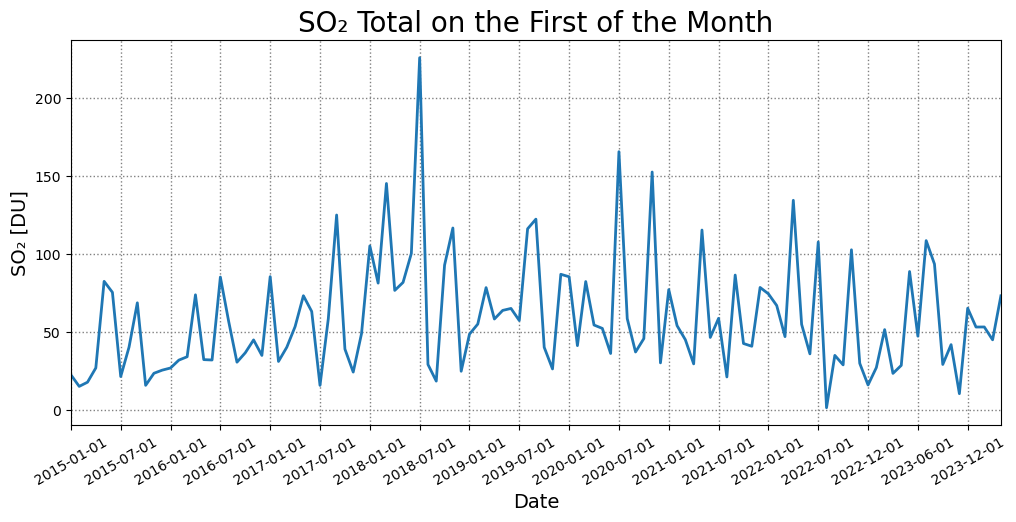

In [13]:
# plot of the total SO2 in the frame in a given month
plt.figure(figsize=(12,5))
plt.plot(df_monthly['date'], df_monthly['so2'], lw=2)
plt.title(u'SO\u2082 Total on the First of the Month', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel(u'SO\u2082 [DU]', fontsize=14)
plt.xticks(df_monthly['date'][::6], rotation=30)
plt.xlim(df_monthly.date[0], df_monthly.date.iloc[-1])
plt.grid(color='gray', lw=1, ls='dotted')
plt.savefig('../figures/so2-monthly-total.png', bbox_inches='tight')
plt.show()

The end of 2017 into the beginning of 2018 was a particularly heavy period for the release of sulfur dioxide.

## Seismic Processing Using USGS NEIC Data

Using the all time [NEIC catalog](https://earthquake.usgs.gov/earthquakes/search/) for earthquakes, download seismic data in a 50km radius of the coordinates of Sabancaya (-15.787&deg; latitude, -71.857&deg; longitude). The USGS will automatically download the search as a CSV files named "query".

In [14]:
# Read .csv into a dataframe, then refine dataframe to depths less than 30km
df_seismic = pd.read_csv('../data/sabancaya/seismic-data/query.csv')
df_seismic_ref = df_seismic[df_seismic['depth'] < 30]

In [15]:
# Map extents for seismic data
extent = [-72.86, -70.86, -14.79, -16.79]
years = np.arange('2011', '2025', dtype='datetime64')

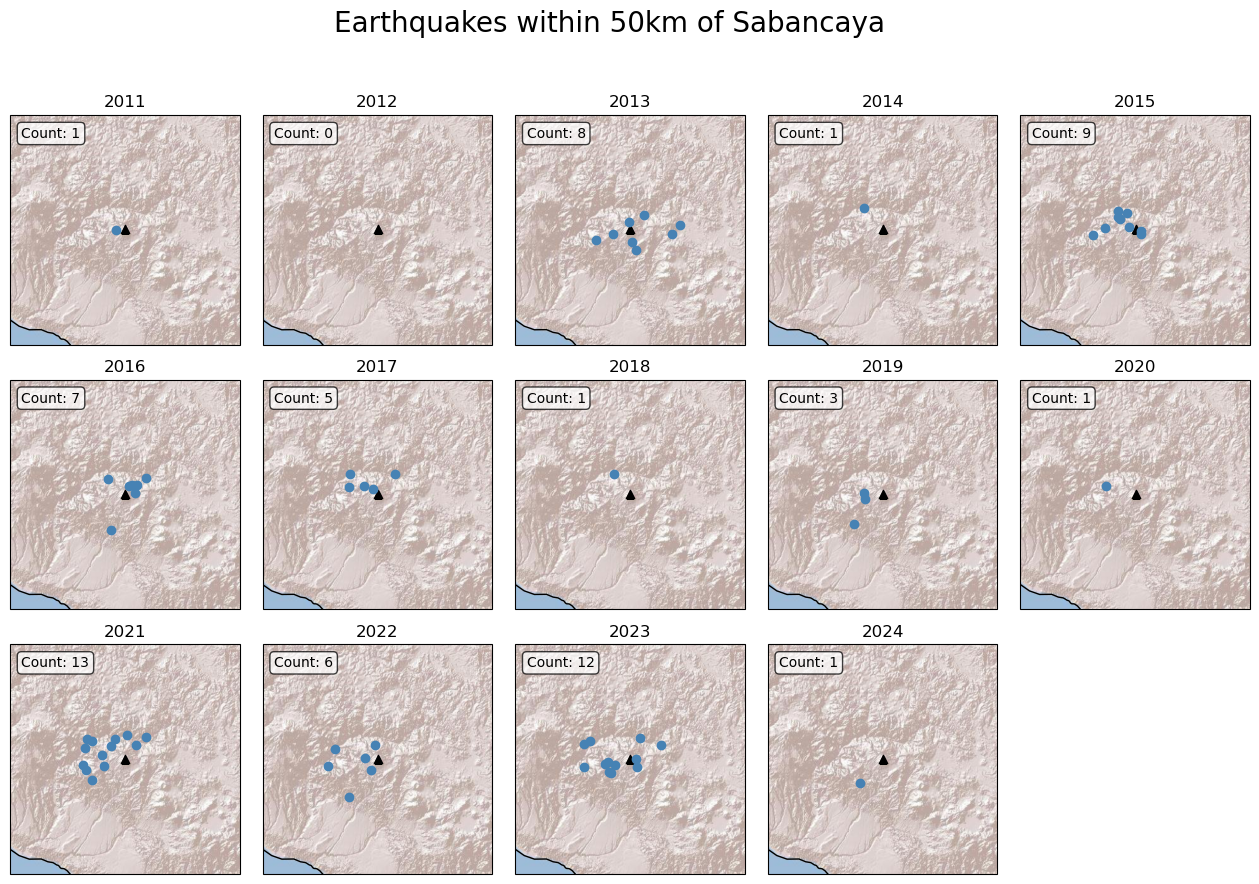

In [16]:
# Plot the seismic data on a geospatial plot with shaded relief by year
bbox = {'boxstyle':'round', 'fc':'white', 'ec':'k', 'alpha':0.75}
fig, axes = plt.subplots(3, 5, figsize=(16,10), subplot_kw={'projection':ccrs.PlateCarree()})
axes = axes.flatten()
yearly_sum_seismic = []

# iterate through the number of years
for i, year in enumerate(years):
    # use query to pull only events from the given year
    df_plot = df_seismic_ref.query(f'time.str.contains("{year}")', engine='python')
    sum = len(df_plot)

    # plot the events on the proper subplot
    ax = axes[i]
    ax.set_extent(extent)
    ax.scatter(lon_sabancaya, lat_sabancaya, marker='^', color='k', transform=ccrs.PlateCarree())
    ax.scatter(df_plot['longitude'], df_plot['latitude'], marker='o', color='steelblue')
    ax.add_image(ShadedReliefESRI(), 8)
    ax.coastlines()
    ax.set_title(f'{year}')
    ax.text((extent[0]+.1), (extent[2]-.1), f'Count: {sum}', transform=ccrs.PlateCarree(), va='top', bbox=bbox)

    # add number of events in the year to a list
    yearly_sum_seismic.append(sum)

# make the last plot invisible becuase of odd number years
axes[-1].set_visible(False)
plt.suptitle("Earthquakes within 50km of Sabancaya", fontsize=20)
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.savefig('../figures/earthquakes.png', bbox_inches='tight')

## Plot Yearly Sum of Seismic Events and Sulfur Dioxide on the Same Plot

Plot the year sum of both seismic data and sulfur dioxide from 2015 to 2023. 2024 is excluded because there has not been a full year of data.

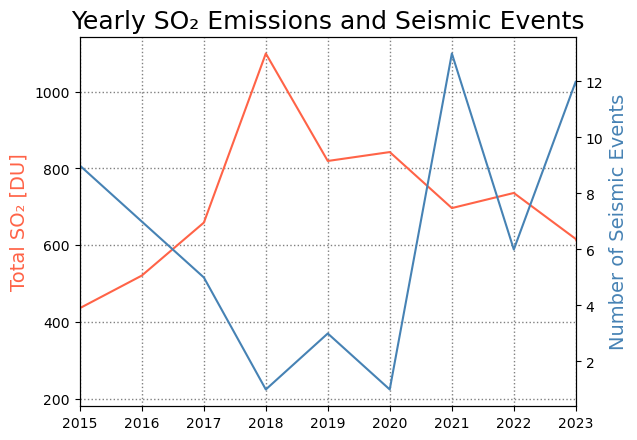

In [17]:
# Plots Total so2 emission and total seismic events in a year on the same plot. 
fig, ax1 = plt.subplots()
plt.title(u'Yearly SO\u2082 Emissions and Seismic Events', fontsize=18)
plt.grid(color='gray', lw=1, ls='dotted')

# plot the SO2 data in 'tomato'
color='tomato'
ax1.plot(years[4:], yearly_sum_so2, color=color)
ax1.set_ylabel(u'Total SO\u2082 [DU]', fontsize=14, color=color)

# Twin the x-axis so there are two separate scales on y-axis
ax2 = ax1.twinx()

# plot the seismic data in 'steel blue'
color = 'steelblue'
ax2.plot(years[4:], yearly_sum_seismic[4:], color=color)
ax2.set_ylabel('Number of Seismic Events', fontsize=14, color=color)
ax2.set_xlim(years[4], years[-2])
plt.savefig('../figures/so2-seismic.png')
plt.show()

Sulfur Dioxide and seismic events seem to have an inverse relationship. When seismic events increase, sulfur dioxide decreases. When seismic events decrease, sulfur dioxide increases.

In [18]:
# Export cleaned seismic data to a CSV file in the data folder
# Allows data to be used in deformation plots
df_seismic_ref.to_csv('../data/refined-seismic.csv')